[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [91]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [92]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [93]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [94]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [95]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

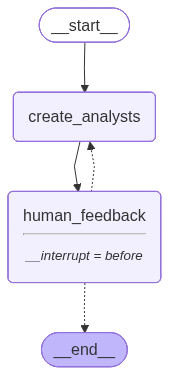

In [96]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [97]:
# Input
max_analysts = 3 
topic = "Defensive and attacking capabilities of FC Barcelona"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Javier Torres
Affiliation: FC Barcelona Tactical Analysis Team
Role: Defensive Strategy Analyst
Description: Javier focuses on analyzing FC Barcelona's defensive formations and strategies. He examines how the team adapts to different opponents and the effectiveness of their defensive transitions. His insights aim to enhance the team's resilience against counter-attacks.
--------------------------------------------------
Name: Maria Gonzalez
Affiliation: Sports Analytics Institute
Role: Attacking Dynamics Analyst
Description: Maria specializes in the attacking capabilities of FC Barcelona, studying player movements, passing patterns, and goal-scoring opportunities. Her work involves using data analytics to identify trends in the team's offensive play and suggesting improvements to maximize scoring potential.
--------------------------------------------------
Name: Luca Romano
Affiliation: Football Tactics Review
Role: Game Theory and Matchup Analyst
Description: Luca analyzes the 

In [98]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [99]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce93e-4fd0-6334-8002-3e0deb94c3df'}}

In [100]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Javier Torres
Affiliation: FC Barcelona Tactical Analysis Team
Role: Defensive Strategy Analyst
Description: Javier focuses on analyzing FC Barcelona's defensive formations and strategies. He examines how the team adapts to different opponents and the effectiveness of their defensive transitions. His insights aim to enhance the team's resilience against counter-attacks.
--------------------------------------------------
Name: Maria Gonzalez
Affiliation: Sports Analytics Institute
Role: Attacking Dynamics Analyst
Description: Maria specializes in the attacking capabilities of FC Barcelona, studying player movements, passing patterns, and goal-scoring opportunities. Her work involves using data analytics to identify trends in the team's offensive play and suggesting improvements to maximize scoring potential.
--------------------------------------------------
Name: Luca Romano
Affiliation: Football Tactics Review
Role: Game Theory and Matchup Analyst
Description: Luca analyzes the 

In [101]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce93e-7ee5-6a5c-8004-500c243f7abc'}}

In [102]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [103]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [104]:
final_state.next

()

In [105]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Javier Torres
Affiliation: FC Barcelona Tactical Analysis Team
Role: Defensive Strategy Analyst
Description: Javier focuses on analyzing FC Barcelona's defensive formations and strategies. He examines how the team adapts to different opponents and the effectiveness of their defensive transitions. His insights are aimed at improving the team's resilience against counter-attacks.
--------------------------------------------------
Name: Maria Gonzalez
Affiliation: La Liga Sports Analytics
Role: Attacking Strategy Analyst
Description: Maria specializes in the attacking capabilities of FC Barcelona, studying player movements, passing patterns, and goal-scoring opportunities. She aims to provide data-driven recommendations to enhance the team's offensive play and maximize their scoring potential.
--------------------------------------------------
Name: Liam Chen
Affiliation: TechStart Sports Innovations
Role: Entrepreneurial Sports Analyst
Description: Liam brings a startup perspective

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [106]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [107]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://docs.langchain.com/oss/python/integrations/document_loaders/web_base)
* Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [108]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [109]:
# Web search tool
from langchain_tavily import TavilySearch  # updated 1.0

tavily_search = TavilySearch(max_results=3)

In [110]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

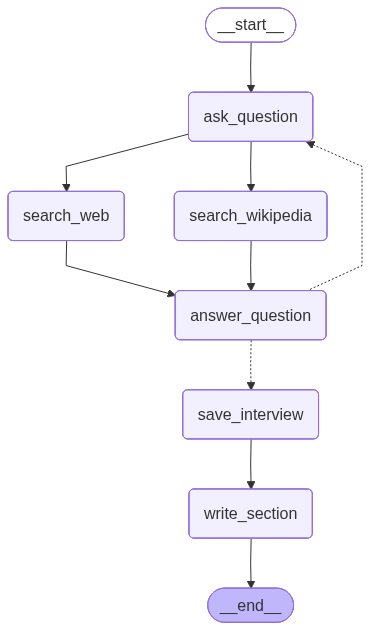

In [111]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    #search_docs = tavily_search.invoke(search_query.search_query) # updated 1.0
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [112]:
# Pick one analyst
analysts[0]

Analyst(affiliation='FC Barcelona Tactical Analysis Team', name='Javier Torres', role='Defensive Strategy Analyst', description="Javier focuses on analyzing FC Barcelona's defensive formations and strategies. He examines how the team adapts to different opponents and the effectiveness of their defensive transitions. His insights are aimed at improving the team's resilience against counter-attacks.")

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [113]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Analyzing FC Barcelona's Defensive Formations and Strategies

### Summary
FC Barcelona has long been recognized for its attacking prowess, but the evolution of its defensive strategies is equally critical to its success. As the team faces a variety of opponents, adapting its defensive formations and tactics has become essential. Recent analyses reveal that Barcelona's high pressing game, while effective, requires constant adjustment to counteract the strategies employed by rival teams. Notably, the team's defensive transitions have been scrutinized, particularly in light of their struggles against low block formations commonly used in La Liga. 

One surprising insight is the impact of Xavi's midfield-heavy lineup, which often includes four or five midfielders. This approach, while aimed at maintaining possession, has inadvertently limited the effectiveness of traditional attacking roles, such as that of a classic number 9. As opponents increasingly adopt high pressing and abandon low block strategies after scoring, Barcelona's ability to adapt defensively becomes paramount. The need for a more flexible defense is underscored by the observation that sometimes the team must drop its pressing strategy to avoid being cut through by opponents' counter-attacks [1][2][3].

Moreover, the analysis highlights the importance of understanding the nuances of football terminology and tactics, which can significantly influence a team's defensive approach. For instance, the distinction between various formations and their implications for defensive resilience is crucial for Barcelona as they navigate the complexities of modern football [4]. The team's ability to transition effectively between different defensive setups will be vital in enhancing their resilience against counter-attacks and maintaining their competitive edge in both domestic and international competitions.

In summary, FC Barcelona's defensive strategies are evolving in response to the challenges posed by their opponents. The insights gathered from recent analyses emphasize the need for adaptability and a deeper understanding of tactical nuances to improve the team's defensive performance.

### Sources
[1] https://templatic.com/primo-explore/scholarship/filedownload.ashx/fc_barcelona_a_tactical_analysis_defending.pdf  
[2] https://medium.com/@r_manulhaq/fc-barcelonas-tactical-struggles-an-in-depth-analysis-e9eee536d5b9  
[3] https://reclaim.cdh.ucla.edu/index.jsp/book-search/FVDbRV/Fc-Barcelona-A-Tactical-Analysis-Defending.pdf  
[4] https://en.wikipedia.org/wiki/Glossary_of_association_football_terms  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [114]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

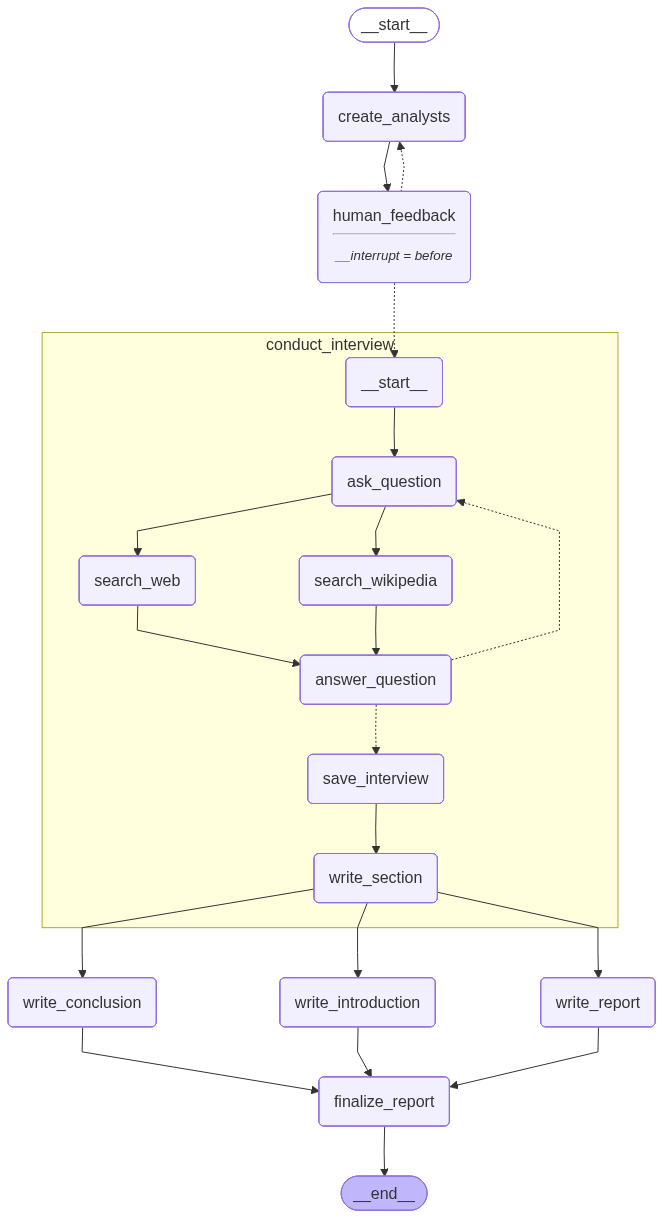

In [115]:
from langgraph.types import Send # updated in 1.0
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [116]:
# Inputs
max_analysts = 3 
topic = "The attacking and defensive capabilities of FC Barcelona"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Javier Torres
Affiliation: FC Barcelona Tactical Analysis Department
Role: Tactical Analyst
Description: Javier focuses on the attacking strategies employed by FC Barcelona, analyzing player movements, formations, and the effectiveness of their offensive plays. His insights aim to enhance the team's scoring capabilities and adapt to opponents' defensive setups.
--------------------------------------------------
Name: Maria Gonzalez
Affiliation: Sports Analytics Firm
Role: Defensive Analyst
Description: Maria specializes in defensive strategies and player performance metrics. She evaluates FC Barcelona's defensive formations, individual player contributions, and overall team resilience against various attacking styles, providing data-driven recommendations for improvement.
--------------------------------------------------
Name: Luca Moretti
Affiliation: Football Strategy Consultant
Role: Game Strategy Analyst
Description: Luca examines the interplay between attacking and defensiv

In [117]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce940-3340-601e-8002-acbaf094e5b2'}}

In [118]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Javier Torres
Affiliation: FC Barcelona Tactical Analysis Department
Role: Tactical Analyst
Description: Javier focuses on the attacking strategies employed by FC Barcelona, analyzing player movements, formations, and the effectiveness of their offensive plays. His insights aim to enhance the team's scoring capabilities and adapt to opponents' defensive setups.
--------------------------------------------------
Name: Maria Gonzalez
Affiliation: Sports Analytics Firm
Role: Defensive Analyst
Description: Maria specializes in defensive strategies and player performance metrics. She evaluates FC Barcelona's defensive formations, individual player contributions, and overall team resilience against various attacking styles, providing data-driven recommendations for improvement.
--------------------------------------------------
Name: Luca Moretti
Affiliation: Football Strategy Consultant
Role: Game Strategy Analyst
Description: Luca examines the interplay between attacking and defensiv

In [119]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ce940-6802-60d6-8004-789406ed88f0'}}

In [120]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [121]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# FC Barcelona: A Tactical Analysis of Attacking and Defensive Capabilities

## Introduction

This report delves into the intricate tactical dynamics of FC Barcelona, focusing on both their attacking and defensive capabilities. We begin by analyzing the evolution of Barcelona's attacking strategies, highlighting their innovative approaches to exploiting defensive weaknesses and maintaining fluidity in play. Next, we explore the club's defensive evolution, tracing the shift from traditional Tiki-Taka principles to a more resilient and adaptable defensive framework. Finally, we synthesize these insights to underscore the systemic challenges facing the team, emphasizing the need for tactical flexibility and innovation in a rapidly changing football landscape.

---


FC Barcelona's tactical approach has evolved significantly, reflecting both their attacking and defensive capabilities in the modern football landscape. The team's attacking strategies are characterized by intricate movements and fluid formations, emphasizing synergy among players. A notable shift has been the adoption of a midfield-heavy lineup, often featuring four or five midfielders, which enhances ball retention and creates scoring opportunities against teams employing low block formations. This tactical adjustment is particularly crucial as traditional forwards, like Lewandowski, face challenges navigating these defensive setups [1][2].

Recent analyses highlight the effectiveness of exploiting "pockets" of space between the opposition's defensive and midfield lines. By positioning attacking midfielders strategically in these areas, Barcelona can create advantageous 2v1 situations against defenders, facilitating quick turns and direct shots on goal [3]. Additionally, the team's ability to absorb pressure and launch immediate counter-attacks has emerged as a key component of their attacking play, allowing them to capitalize on the disorganization of opponents following possession regains [4]. The synergy between forwards and midfielders is essential for maintaining fluidity in attacking movements, making it difficult for defenders to predict Barcelona's next move [5].

On the defensive front, Barcelona's tactics have undergone a significant transformation from the Tiki-Taka era to a more resilient and adaptable approach. The team's defensive effectiveness has fluctuated, particularly during the 2018-19 season, where initial success with a high defensive line and aggressive pressing waned as the season progressed [1][3]. However, the current season has seen Barcelona on track for a record-breaking defensive performance, having conceded only seven goals in twenty-two league matches, showcasing the effectiveness of their modern defensive formations [4][5].

The evolution of defensive tactics has necessitated individual player contributions within the team's framework, requiring players to exhibit versatility and transition seamlessly between defensive duties and offensive support. This adaptability is crucial in countering the high-pressing and counter-pressing tactics employed by opponents [6][7]. The shift towards a more structured defensive organization has allowed Barcelona to withstand the pressures of modern attacking styles, enhancing team resilience and providing a foundation for future tactical innovations [2][8].

Despite the strengths in both attacking and defensive strategies, recent metrics indicate a concerning decline in goal-scoring efficiency, with the team ending 2023 with 25 goals less than the record set by Lionel Messi in 2012 [2]. This juxtaposition of declining offensive output alongside defensive vulnerabilities presents a unique challenge for the coaching staff. The role of midfielders has become increasingly critical in both disrupting opposing attacks and facilitating offensive plays, highlighting the need for tactical flexibility [3].

In conclusion, FC Barcelona's current tactical landscape reflects a blend of traditional principles and innovative adaptations. The club's ability to innovate and adapt its strategies will be crucial in influencing coaching decisions and game strategies moving forward, as they seek to regain their status as one of Europe's most formidable teams.


---

## Conclusion

FC Barcelona's current tactical landscape reveals a complex interplay between their attacking and defensive capabilities. While the team has historically excelled in dynamic offensive play, recent analyses indicate a worrying decline in both goal-scoring efficiency and defensive solidity. The shift towards a midfield-heavy approach aims to enhance ball retention and exploit spaces, yet the team struggles against modern defensive setups. Additionally, the evolution of defensive tactics from Tiki-Taka to a more resilient structure highlights the need for adaptability. As Barcelona navigates these challenges, a comprehensive tactical overhaul will be essential for reclaiming their status as a dominant force in European football.

## Sources
[1] https://www.tiktok.com/@hamidsahari1/video/7570850909517892877  
[2] https://medium.com/@r_manulhaq/fc-barcelonas-tactical-struggles-an-in-depth-analysis-e9eee536d5b9  
[3] https://the-footballanalyst.com/hansi-flick-fc-barcelona-tactical-analysis/  
[4] https://www.adiralsport.com/fc-barcelona-vs-olympiacos-tactical-analysis/  
[5] https://spielverlagerung.com/2020/04/11/barcelonas-high-pressing-strategy-vs-napoli/  
[6] https://www.facebook.com/groups/816119582575353/posts/2039364896917476/  
[7] https://en.wikipedia.org/wiki/History_of_tactics_in_association_football  
[8] https://themastermindsite.com/2023/03/02/xavi-hernandez-barcelona-tactical-analysis-2022-23/  
[9] https://totalfootballanalysis.com/team-analysis/barcelona-202324-defensive-deficiencies-scout-report-tactical-analysis-tactics  
[10] https://medium.com/@Am10talk/barcelona-2023-24-the-distasteful-end-to-xavis-successful-era-48e41063687e

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r

In [122]:
# Print the number of analysts in the final report
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts', [])
print(f"Number of analysts in final report: {len(analysts)}")

Number of analysts in final report: 3
